In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import json
import random

In [33]:
# Set seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [34]:
# 1. Load the data
data = pd.read_csv('data/SP500.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# round to 2 decimal places
data = data.round(2) 

In [35]:
# 2. Preprocess the data
features = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

# Verify that data[:, 3] refers to the 'Close' price
assert(data.columns[3] == 'Close')

In [36]:
# 3. Load & extract hyperparameters

# Load hyperparameters
with open('configs/configs.json', 'r') as file:
    hyperparams = json.load(file)

# Extract hyperparameters
seq_length = hyperparams['seq_length']
lstm_units = hyperparams['lstm_units']
dropout_rate = hyperparams['dropout_rate']
dense_units = hyperparams['dense_units']
batch_size = hyperparams['batch_size']
epochs = hyperparams['epochs']
use_early_stop = hyperparams['use_early_stop']
early_stop_patience = hyperparams['early_stop_patience']

In [37]:
# 4. Create sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # Assuming 'Close' price is the target
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, seq_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [38]:
# 5. Build the LSTM model
model = Sequential()
model.add(LSTM(lstm_units, return_sequences=True, input_shape=(seq_length, 6)))
model.add(Dropout(dropout_rate))
model.add(LSTM(lstm_units, return_sequences=False))
model.add(Dropout(dropout_rate))
model.add(Dense(dense_units))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [39]:
# 6. Train the model
if use_early_stop:
    early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_patience)
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stop])
else:
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/100


2024-07-04 15:22:17.539478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 15:22:17.711054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 15:22:17.825469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 15:22:17.962858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/212 [..............................] - ETA: 5:45 - loss: 0.0197

2024-07-04 15:22:18.174062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


212/212 [==============================] - ETA: 0s - loss: 2.5702e-04

2024-07-04 15:22:25.276625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 15:22:25.332063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 15:22:25.409493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


212/212 [==============================] - 10s 38ms/step - loss: 2.5702e-04 - val_loss: 1.9234e-04
Epoch 2/100
212/212 [==============================] - 7s 34ms/step - loss: 4.4685e-05 - val_loss: 1.9928e-04
Epoch 3/100
212/212 [==============================] - 7s 34ms/step - loss: 3.8906e-05 - val_loss: 2.2295e-04
Epoch 4/100
212/212 [==============================] - 7s 34ms/step - loss: 3.6680e-05 - val_loss: 1.3189e-04
Epoch 5/100
212/212 [==============================] - 7s 35ms/step - loss: 3.0137e-05 - val_loss: 0.0014
Epoch 6/100
212/212 [==============================] - 7s 33ms/step - loss: 4.0714e-05 - val_loss: 1.5032e-04
Epoch 7/100
212/212 [==============================] - 7s 35ms/step - loss: 3.0185e-05 - val_loss: 1.8401e-04
Epoch 8/100
212/212 [==============================] - 7s 34ms/step - loss: 2.3244e-05 - val_loss: 2.1535e-04
Epoch 9/100
212/212 [==============================] - 7s 35ms/step - loss: 2.5260e-05 - val_loss: 1.8767e-04
Epoch 10/100
212/212 [===

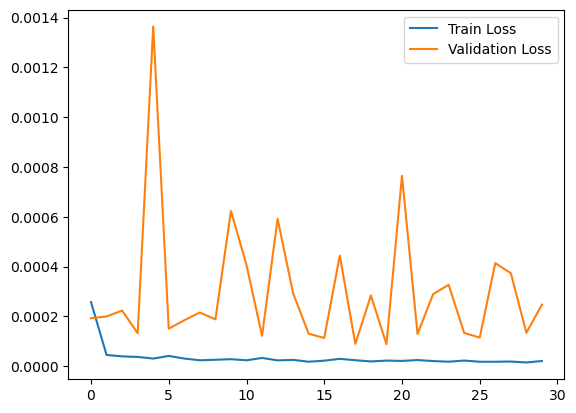

In [40]:
# 7. Evaluate the model 
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [41]:
# 8. Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to the original scale
predictions_rescaled = np.zeros_like(scaled_data)
predictions_rescaled[:, 3] = np.nan  # Fill the 'Close' column
predictions_rescaled[split+seq_length:, 3] = predictions[:, -1]
predictions_rescaled = scaler.inverse_transform(predictions_rescaled)

# Extract actual close prices and ensure they're in the right shape for comparison
actual_prices = scaled_data[split+seq_length:, 3]
actual_prices_rescaled = scaler.inverse_transform(np.hstack((np.zeros((len(actual_prices), scaled_data.shape[1] - 1)), actual_prices.reshape(-1, 1))))
actual_prices_rescaled = actual_prices_rescaled[:, -1]

2024-07-04 15:25:55.674045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 15:25:55.746574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-04 15:25:55.834510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


106/106 [==============================] - 2s 16ms/step


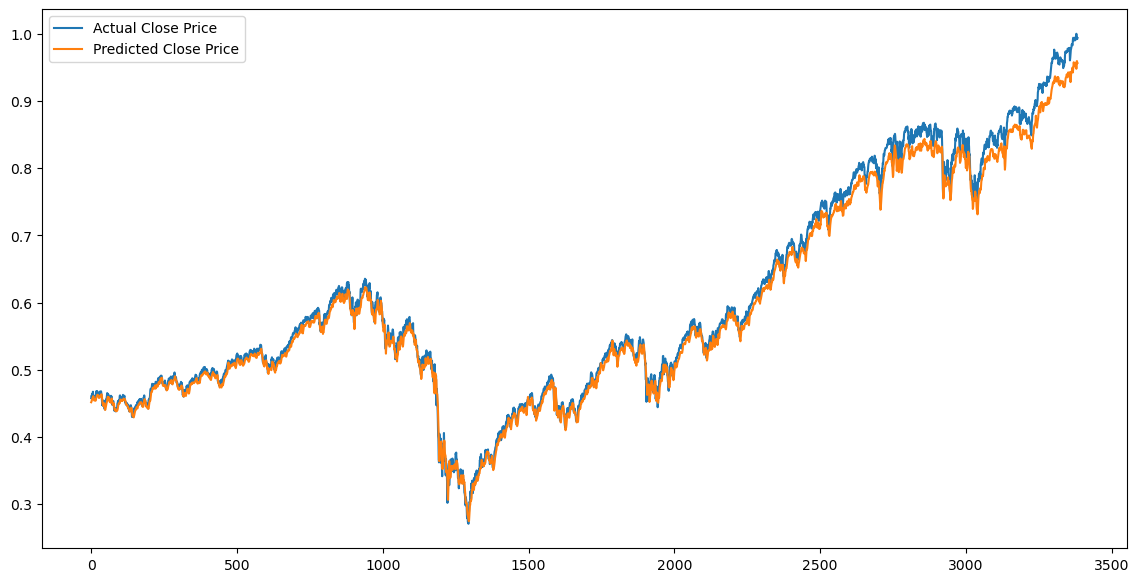

In [42]:
# 9. Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label='Actual Close Price')
plt.plot(predictions[:, -1], label='Predicted Close Price')
plt.legend()
plt.show()

In [43]:
# 10. Final evaluation of model
mae = mean_absolute_error(actual_prices, predictions[:, -1])
mse = mean_squared_error(actual_prices, predictions[:, -1])
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.012395268096935386
Mean Squared Error (MSE): 0.000246755177173039
Root Mean Squared Error (RMSE): 0.015708442862774116
